In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import os
import glob
from tqdm.notebook import tqdm
from IPython.display import HTML, Image as ipython_image
from functools import partial

import matplotlib.pylab
matplotlib.pylab.rcParams['figure.dpi'] = 200

# Video analysis

I've simulated video data of a blob moving across a space of 128 x 128px (yay for powers of 2 this time). 

The blob is itself just an evaluation of a 2d gaussian kernel in the image space (which is a function of distance from center, a radius parameter, and a probability value for the center of the blob)

Each frame the effect of the blob is to sample from a Bernoulli distribution at every pixel, with probabilty given by the blob's values over the image space. In the end, we obtain a layer of what I'll call "claims" resulting from the movement of the blob, where each pixel in the image has values `{0, 1, ..., n_frames}`. Intuitively, more claims are generated closer to the center of the blob as it moves across the space.

In [19]:
VIDEO_DIR = 'simvid'

def sort_folders(folders, split_idx):
    idx = [int(x.split("_")[split_idx]) for x in folders]
    folders = [x for _, x in sorted(zip(idx, folders))]
    idx.sort()
    return folders, idx


def sort_files(files, split_idx):
    """
    Sort files based on the third element in the image file name within the video directory.
    Videos are named like so [blob|claim]_frame_##.png. Sorting is done on the third element, or index 2.
    """
    files = [os.path.splitext(x)[0] for x in files]
    idx = [int(x.split("_")[split_idx]) for x in files]
    files = [x for _, x in sorted(zip(idx, files))]
    idx.sort()
    return files, idx

video_dirs, video_idx = sort_folders(os.listdir(VIDEO_DIR), 1)


In [20]:
file_df = pd.DataFrame({
    "video_no": video_idx,
    "video_dirs": video_dirs,
    "train": random.choices([0, 1], weights = [0.2, 0.8], k=len(video_dirs))
})

file_df.head()

,video_no,video_dirs,train
0,0,blob_0_direction141.5_speed2.6_x53.0_y32.0_rad...,1
1,1,blob_1_direction-154.0_speed3.3_x89.0_y82.0_ra...,1
2,2,blob_2_direction-196.7_speed0.5_x74.0_y55.0_ra...,0
3,3,blob_3_direction36.9_speed0.7_x111.0_y121.0_ra...,1
4,4,blob_4_direction158.0_speed1.6_x0.0_y32.0_radi...,0


In [21]:
class CustomVideoDataset(Dataset):
    def __init__(self, df, parent_dir, transform_img):
        self.parent_dir = parent_dir
        self.videos = df.video_dirs.tolist()
        self.transform_img = transform_img
    def __len__(self):
        return len(self.videos)
    def __getitem__(self, idx):
        # Get frames from video set
        video_dir = os.path.join(self.parent_dir, self.videos[idx])
        # Get blob files
        blob_frame_files = glob.glob("blob*", root_dir=video_dir)
        blob_frame_files, _ = sort_files(blob_frame_files, 2)
        blob_frame_files = [os.path.join(video_dir, x + '.png') for x in blob_frame_files]
        blob_frame_images = [self.transform_img(Image.open(x)) for x in blob_frame_files]
        blob_tensor = torch.stack(blob_frame_images, dim=1)
        # Get claims data files
        claims_data_files = glob.glob("claims_data_*.png", root_dir=video_dir)
        claims_data_files, _ = sort_files(claims_data_files, 2)
        claims_data_files = [os.path.join(video_dir, x + '.png') for x in claims_data_files]
        claims_data_images = [self.transform_img(Image.open(x)) for x in claims_data_files]
        claims_final_state = claims_data_images[-1]
        claims_tensor = torch.stack(claims_data_images, dim=1)
        # Get final claims state
        return blob_frame_images, blob_tensor, claims_data_images, claims_tensor, claims_final_state



In [22]:
file_df.query("train == 1")

,video_no,video_dirs,train
0,0,blob_0_direction141.5_speed2.6_x53.0_y32.0_rad...,1
1,1,blob_1_direction-154.0_speed3.3_x89.0_y82.0_ra...,1
3,3,blob_3_direction36.9_speed0.7_x111.0_y121.0_ra...,1
5,5,blob_5_direction-55.4_speed3.3_x35.0_y30.0_rad...,1
8,8,blob_8_direction-13.7_speed4.3_x94.0_y105.0_ra...,1
...,...,...,...
92,92,blob_92_direction-103.7_speed1.9_x109.0_y19.0_...,1
93,93,blob_93_direction189.0_speed3.3_x96.0_y29.0_ra...,1
95,95,blob_95_direction138.0_speed3.2_x2.0_y51.0_rad...,1
98,98,blob_98_direction-186.6_speed2.4_x110.0_y2.0_r...,1


Below, I show an example of a blob as it moves over the state space. The image
below is normalized so that the highest value is pure white, but the blob's
center can have a max value of anywhere between 0-1.

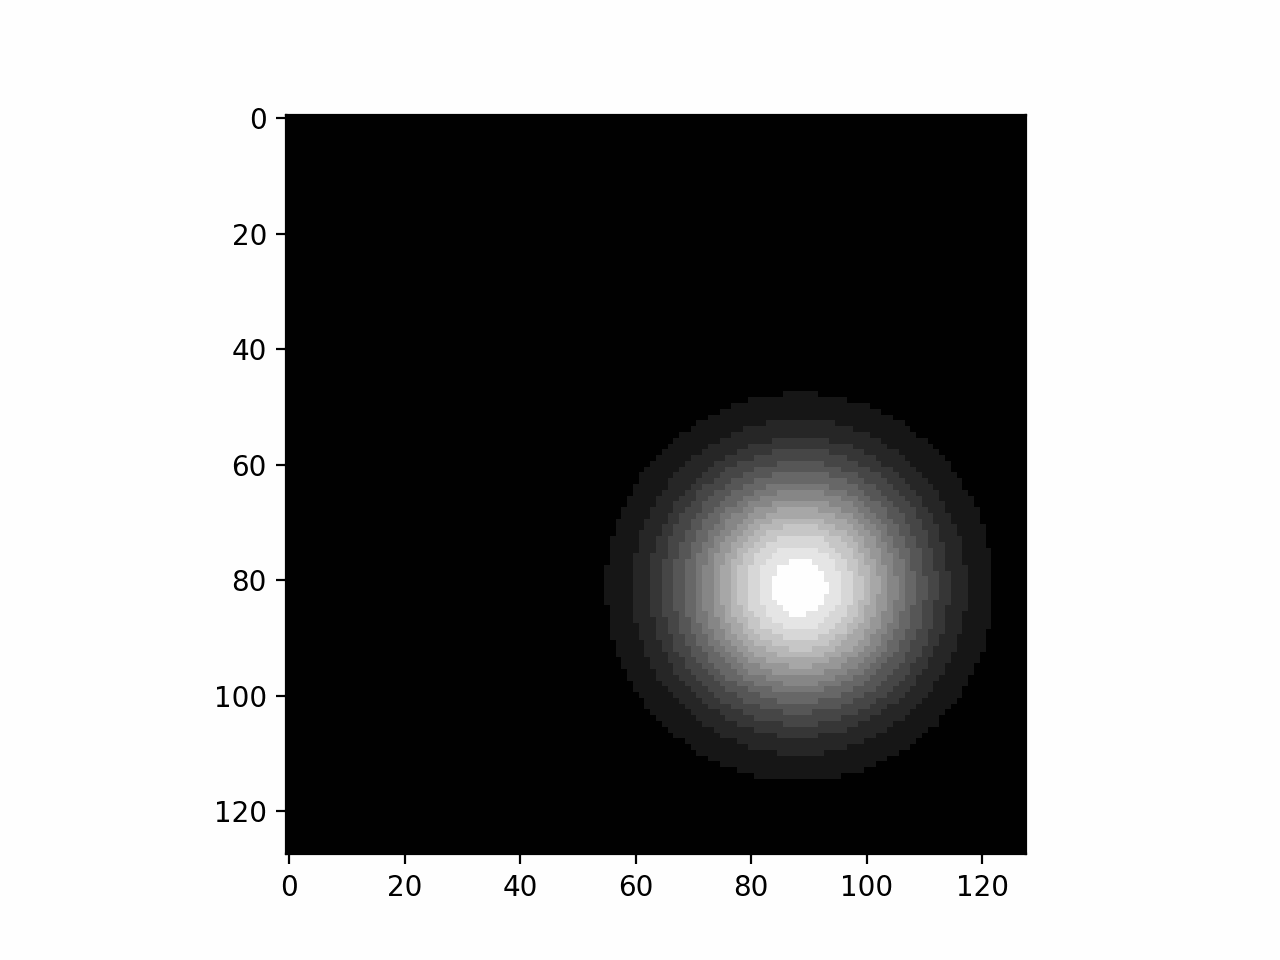

In [23]:
transform_img = transforms.Compose(
    [
        transforms.Grayscale(1),
        transforms.ToTensor()
    ]
)

traindata = CustomVideoDataset(
    file_df.query("train == 1"), VIDEO_DIR, transform_img
)
train_dataloader = DataLoader(traindata, batch_size=4, shuffle=True)

blob, blob_tensor, claims, claims_tensor, final_state = traindata.__getitem__(1)
fig, ax = plt.subplots()
plt.close() # Need to do this or jupyter will display a plot after the html animation.

def update(i, imgset):
    ax.clear()
    ax.imshow(imgset[i].permute(1,2,0).numpy(), cmap='gray')

ani = animation.FuncAnimation(fig, partial(update, imgset=blob), frames = len(blob), interval = 50)
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('output_images/blob.gif', writer=writer)
ipython_image('output_images/blob.gif')


As the blob moves across the space, it "deposits" (integer) events as a result
of a Bernoulli sampled each frame with probability based on the blob's
"brightness" -- higher brightness means higher probability of depositing an
event. This intuitively results in more events accumulating in the center of the
blob's path, and fewer farther away from the center. This also means the size,
and rate of movement of the blob influence how many events accumulate in the
state space.

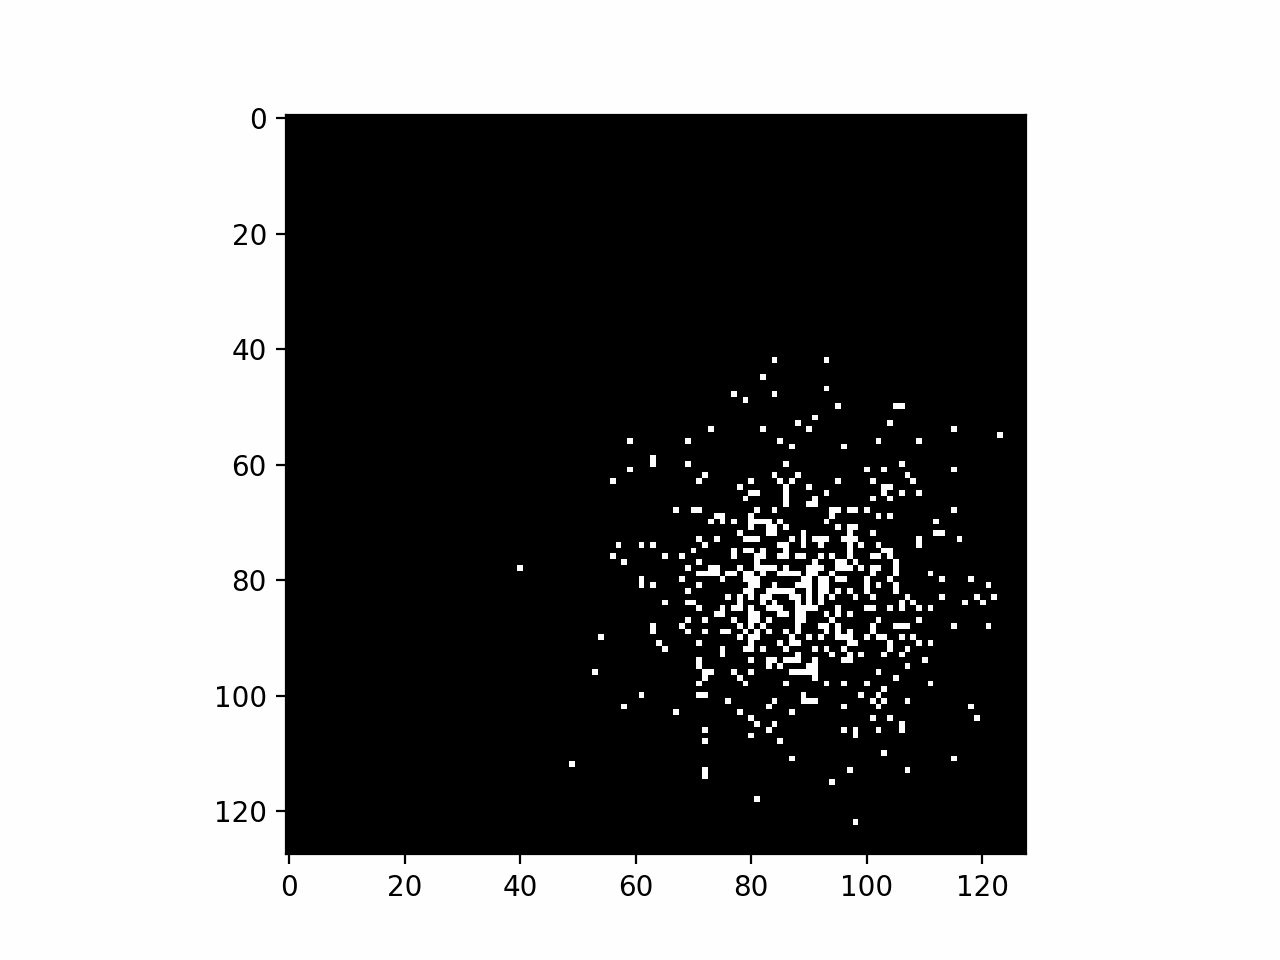

In [24]:
ani = animation.FuncAnimation(fig, partial(update, imgset=claims), frames = len(claims), interval = 50)
ani.save('output_images/claims.gif', writer=writer)
ipython_image('output_images/claims.gif')

The objective here is to show the neural network the blob's movement and have it
predict the *final* accumulation of events. In a real-life scenario, we are
interested in knowing the end state, but have perhaps limited information at a
time before the "hurricane" "blob" has completed its motion, so we want to
create a model that can predict the end state from limited information.

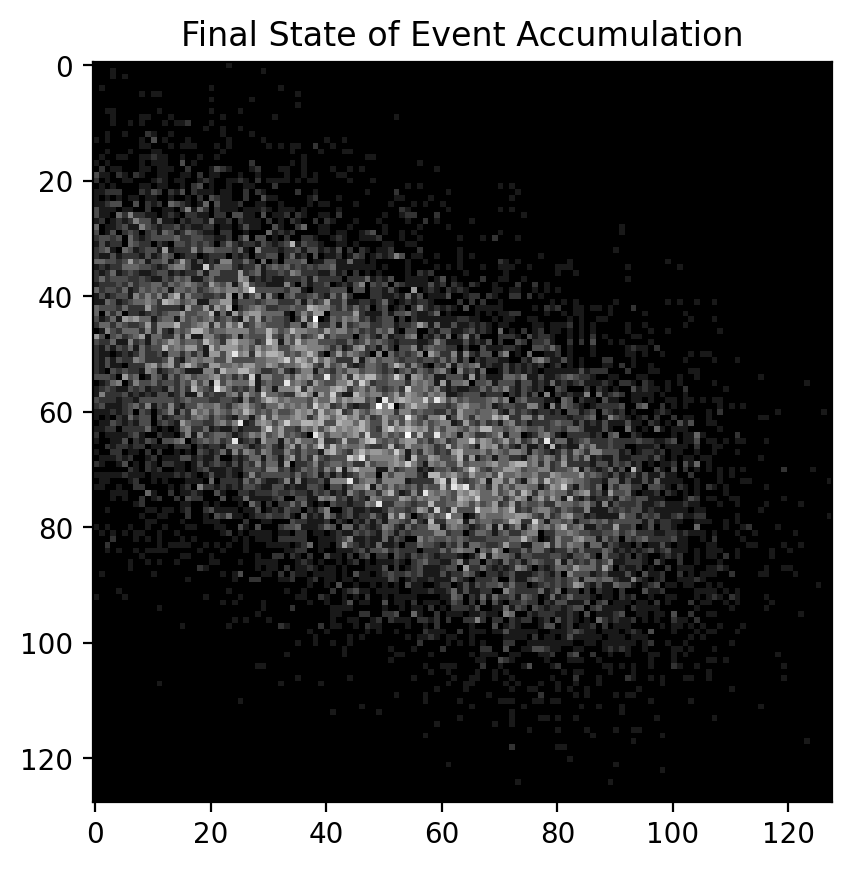

In [25]:
plt.imshow(final_state.permute(1,2,0).numpy(), cmap='gray')
plt.title("Final State of Event Accumulation")
plt.show()

# Building the model

I'll attempt to use a slightly modified but pre-built VideoResnet transformer to model this. 

In [9]:
from torchvision.models.video.resnet import Bottleneck, BasicBlock, Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D
from typing import Any, Callable, List, Optional, Sequence, Tuple, Type, Union
from torch import Tensor

class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        # num_classes: int = 400, # We aren't classifying here.
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()
        # _log_api_usage_once(self)

        self.verbose = verbose

        self.inplanes = 64

        self.stem = stem()

        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)
        # Back up to original
        self.layer5 = nn.ConvTranspose3d(512, 256, kernel_size=(2,2,2), stride=(2,2,2))
        self.layer6 = nn.ConvTranspose3d(256, 128, kernel_size=(1,2,2), stride=(2,2,2))
        self.layer7 = nn.ConvTranspose3d(128,  64, kernel_size=(2,2,2), stride=(2,2,2))
        self.layer8 = nn.ConvTranspose3d(64,    1, kernel_size=(1,2,2), stride=(1,2,2))

        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))
        # self.fc = nn.Linear(512 * block.expansion, num_classes) # Not classifying

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        x = self.stem(x)
        self.print_verbose(x.shape)
        x = self.layer1(x)
        self.print_verbose(x.shape)
        x = self.layer2(x)
        self.print_verbose(x.shape)
        x = self.layer3(x)
        self.print_verbose(x.shape)
        x = self.layer4(x)
        self.print_verbose(x.shape)
        x = self.layer5(x)
        self.print_verbose(x.shape)
        x = self.layer6(x)
        self.print_verbose(x.shape)
        x = self.layer7(x)
        self.print_verbose(x.shape)
        x = self.layer8(x)
        self.print_verbose(x.shape)
        x = self.avgpool(x)
        self.print_verbose(x.shape)
        x = torch.squeeze(x, 2)
        self.print_verbose(x.shape)
        # Flatten the layer to fc # Skip not classifying
        # x = x.flatten(1)
        # x = self.fc(x)
        return x

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)




In [10]:
net = VideoResNet(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=True)


In [11]:
blob, blob_tensor, claims, claims_tensor, final_state = next(iter(train_dataloader))
print(blob_tensor.shape)
print(final_state.shape)

torch.Size([4, 1, 30, 128, 128])
torch.Size([4, 1, 128, 128])


In [12]:
# Test dimensions over the architecture
net(blob_tensor)

Starting
torch.Size([4, 64, 30, 64, 64])
torch.Size([4, 64, 30, 64, 64])
torch.Size([4, 128, 15, 32, 32])
torch.Size([4, 256, 8, 16, 16])
torch.Size([4, 512, 4, 8, 8])
torch.Size([4, 256, 8, 16, 16])
torch.Size([4, 128, 15, 32, 32])
torch.Size([4, 64, 30, 64, 64])
torch.Size([4, 1, 30, 128, 128])
torch.Size([4, 1, 1, 128, 128])
torch.Size([4, 1, 128, 128])


tensor([[[[0.3537, 0.2485, 0.3325,  ..., 0.2470, 0.3337, 0.2377],
          [0.2693, 0.2914, 0.2854,  ..., 0.2640, 0.2719, 0.2669],
          [0.3224, 0.2266, 0.3192,  ..., 0.2260, 0.3258, 0.2629],
          ...,
          [0.2652, 0.2914, 0.2759,  ..., 0.2668, 0.2931, 0.2563],
          [0.3530, 0.2268, 0.3254,  ..., 0.2257, 0.3024, 0.2652],
          [0.2799, 0.2666, 0.2630,  ..., 0.2732, 0.2407, 0.2645]]],


        [[[0.3537, 0.2485, 0.3325,  ..., 0.2469, 0.3337, 0.2378],
          [0.2693, 0.2914, 0.2854,  ..., 0.2640, 0.2717, 0.2669],
          [0.3224, 0.2266, 0.3193,  ..., 0.2261, 0.3256, 0.2630],
          ...,
          [0.2666, 0.2941, 0.2767,  ..., 0.2757, 0.2827, 0.2761],
          [0.3503, 0.2255, 0.3246,  ..., 0.2274, 0.3087, 0.2643],
          [0.2834, 0.2683, 0.2577,  ..., 0.2761, 0.2434, 0.2670]]],


        [[[0.3500, 0.2369, 0.3276,  ..., 0.2470, 0.3335, 0.2385],
          [0.3069, 0.2700, 0.2680,  ..., 0.2643, 0.2718, 0.2663],
          [0.3469, 0.2157, 0.2978,  ..

## Fitting the model

In [13]:
net = VideoResNet(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem).to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss = []
epoch_loss = []
for epoch in tqdm(range(20)):
    for i, data in enumerate(train_dataloader):
        blob, blob_tensor, claims, claims_tensor, final_state  = data
        blob_tensor = blob_tensor.to("cuda")
        final_state = final_state.to("cuda")
        optimizer.zero_grad()
        output_tensor = net(blob_tensor)
        loss_tensor = nn.MSELoss()(
            output_tensor, final_state
        )
        loss_tensor.backward()
        train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
        optimizer.step()
    epoch_loss_one = np.mean(train_loss)
    epoch_loss.append(epoch_loss_one)

  0%|          | 0/20 [00:00<?, ?it/s]

## Training loss

Text(0, 0.5, 'Loss (MSE)')

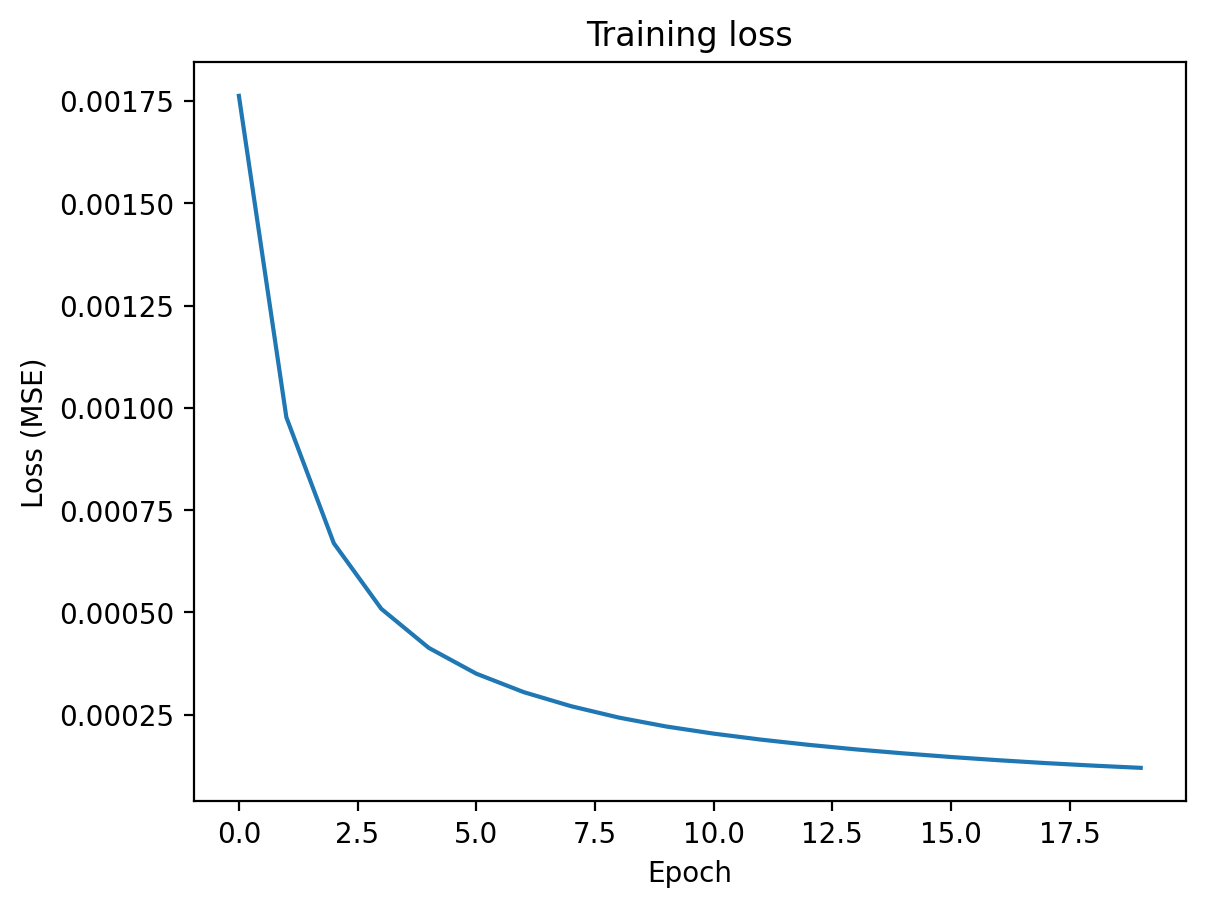

In [14]:
plt.plot(epoch_loss)
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

## Views of prediction on test data

In [15]:
testdata = CustomVideoDataset(
    file_df.query("train == 0"), VIDEO_DIR, transform_img
)
test_dataloader  = DataLoader(testdata,  batch_size=12, shuffle=True)


blob, blob_tensor, claims, claims_tensor, final_state  = next(iter(test_dataloader))

blob_tensor = blob_tensor.to("cuda")
final_state = final_state.to("cuda")
output_tensor = net(blob_tensor)
output_tensor = output_tensor.cpu()

output_tensor.shape

torch.Size([12, 1, 128, 128])

Below we observe the output surfaces predicted by the neural network. It does a
mediocre job of predicting the ultimate state, but the output is extremely noisy
and inconsistent.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


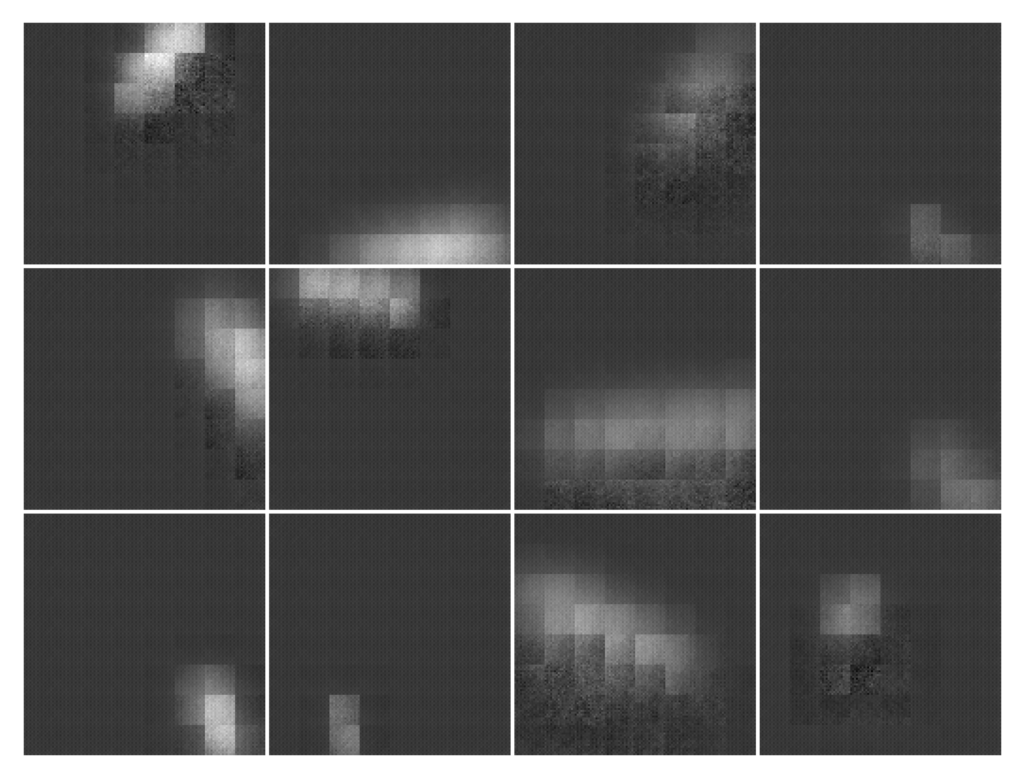

In [16]:
plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Compare the above with the true final state for each "blob".

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


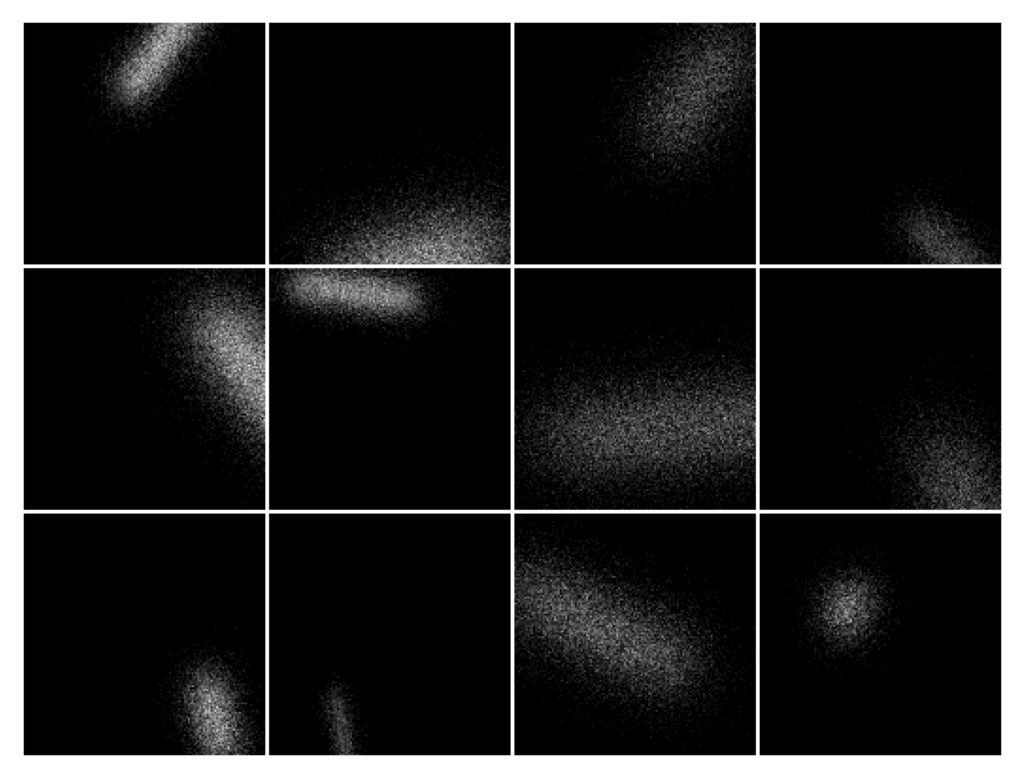

In [17]:
plt.imshow(
    torchvision.utils.make_grid(final_state.cpu(), nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()